In [59]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(gridExtra)
library(cowplot)
options(repr.matrix.max.rows = 6)

# Predicting the length of tennis games using previous winners' height and age

## Introduction

In the dataset provided by Jeff Sackman, data from tennis matches played by the top 500 players from 2017 to 2019 are provided, with game statistics as well as winner and loser attributes. The data contains 6866 rows of games played in many tournaments from 2017 to 2019. The attributes given include information of the match such as its date, location, type of surface (hard, grass, etc), as well as the length of the match. Information is also given regarding the winners and losers, such as their height, age, dominant hand, and seed **description  and reference needed** Based on these data, we will use multivariable linear regression to predict the length of future tennis matches based on the height and age of winners of previously played tennis matches. Using these data, we will attempt to answer the question: can we predict the length of tennis matches based on the age and height of previous winners? 


In [60]:
tennis_data <- read_csv("https://raw.githubusercontent.com/keelbeier/dsci100-group69/main/atp2017-2019.csv")
tennis_data

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2883,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,2,104542,NA,⋯,54,30,12,12,5,11,15,2320,76,667
2884,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,4,105676,NA,⋯,54,44,13,14,7,10,7,3775,15,2320
2885,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,5,106298,NA,⋯,53,29,11,11,4,11,18,2235,76,667



Above: our csv file read into R

## Methods

Now, we will wrangle our data into a tidy format. We will remove all columns that we do not need.

In [61]:
tennis_data <- tennis_data |>
                    select(tourney_date, 
                      winner_age, loser_age, winner_ht, loser_ht, minutes) |>
                    mutate(winner_age = round(winner_age)) |>
                    mutate(loser_age = round(loser_age))|>
                    filter(winner_ht != "NA")
tennis_data

tourney_date,winner_age,loser_age,winner_ht,loser_ht,minutes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20181231,29,23,178,NA,124
20181231,29,32,178,188,66
20181231,34,20,188,NA,106
⋮,⋮,⋮,⋮,⋮,⋮
20171124,33,34,188,178,106
20171124,27,33,163,188,164
20171124,24,34,185,178,94


In [64]:
tennis_parameter <- tennis_data |>
    summarize(med_winner_age = median(winner_age), 
              med_loser_age = median(loser_age), 
              med_winner_ht = median(winner_ht), 
              med_loser_ht = median(loser_ht, na.rm = TRUE), 
              med_minute = median(minutes, na.rm = TRUE))
tennis_parameter

med_winner_age,med_loser_age,med_winner_ht,med_loser_ht,med_minute
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30,28,185,185,104


Warning message:
“Removed 1758 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 73 rows containing non-finite values (stat_bin).”


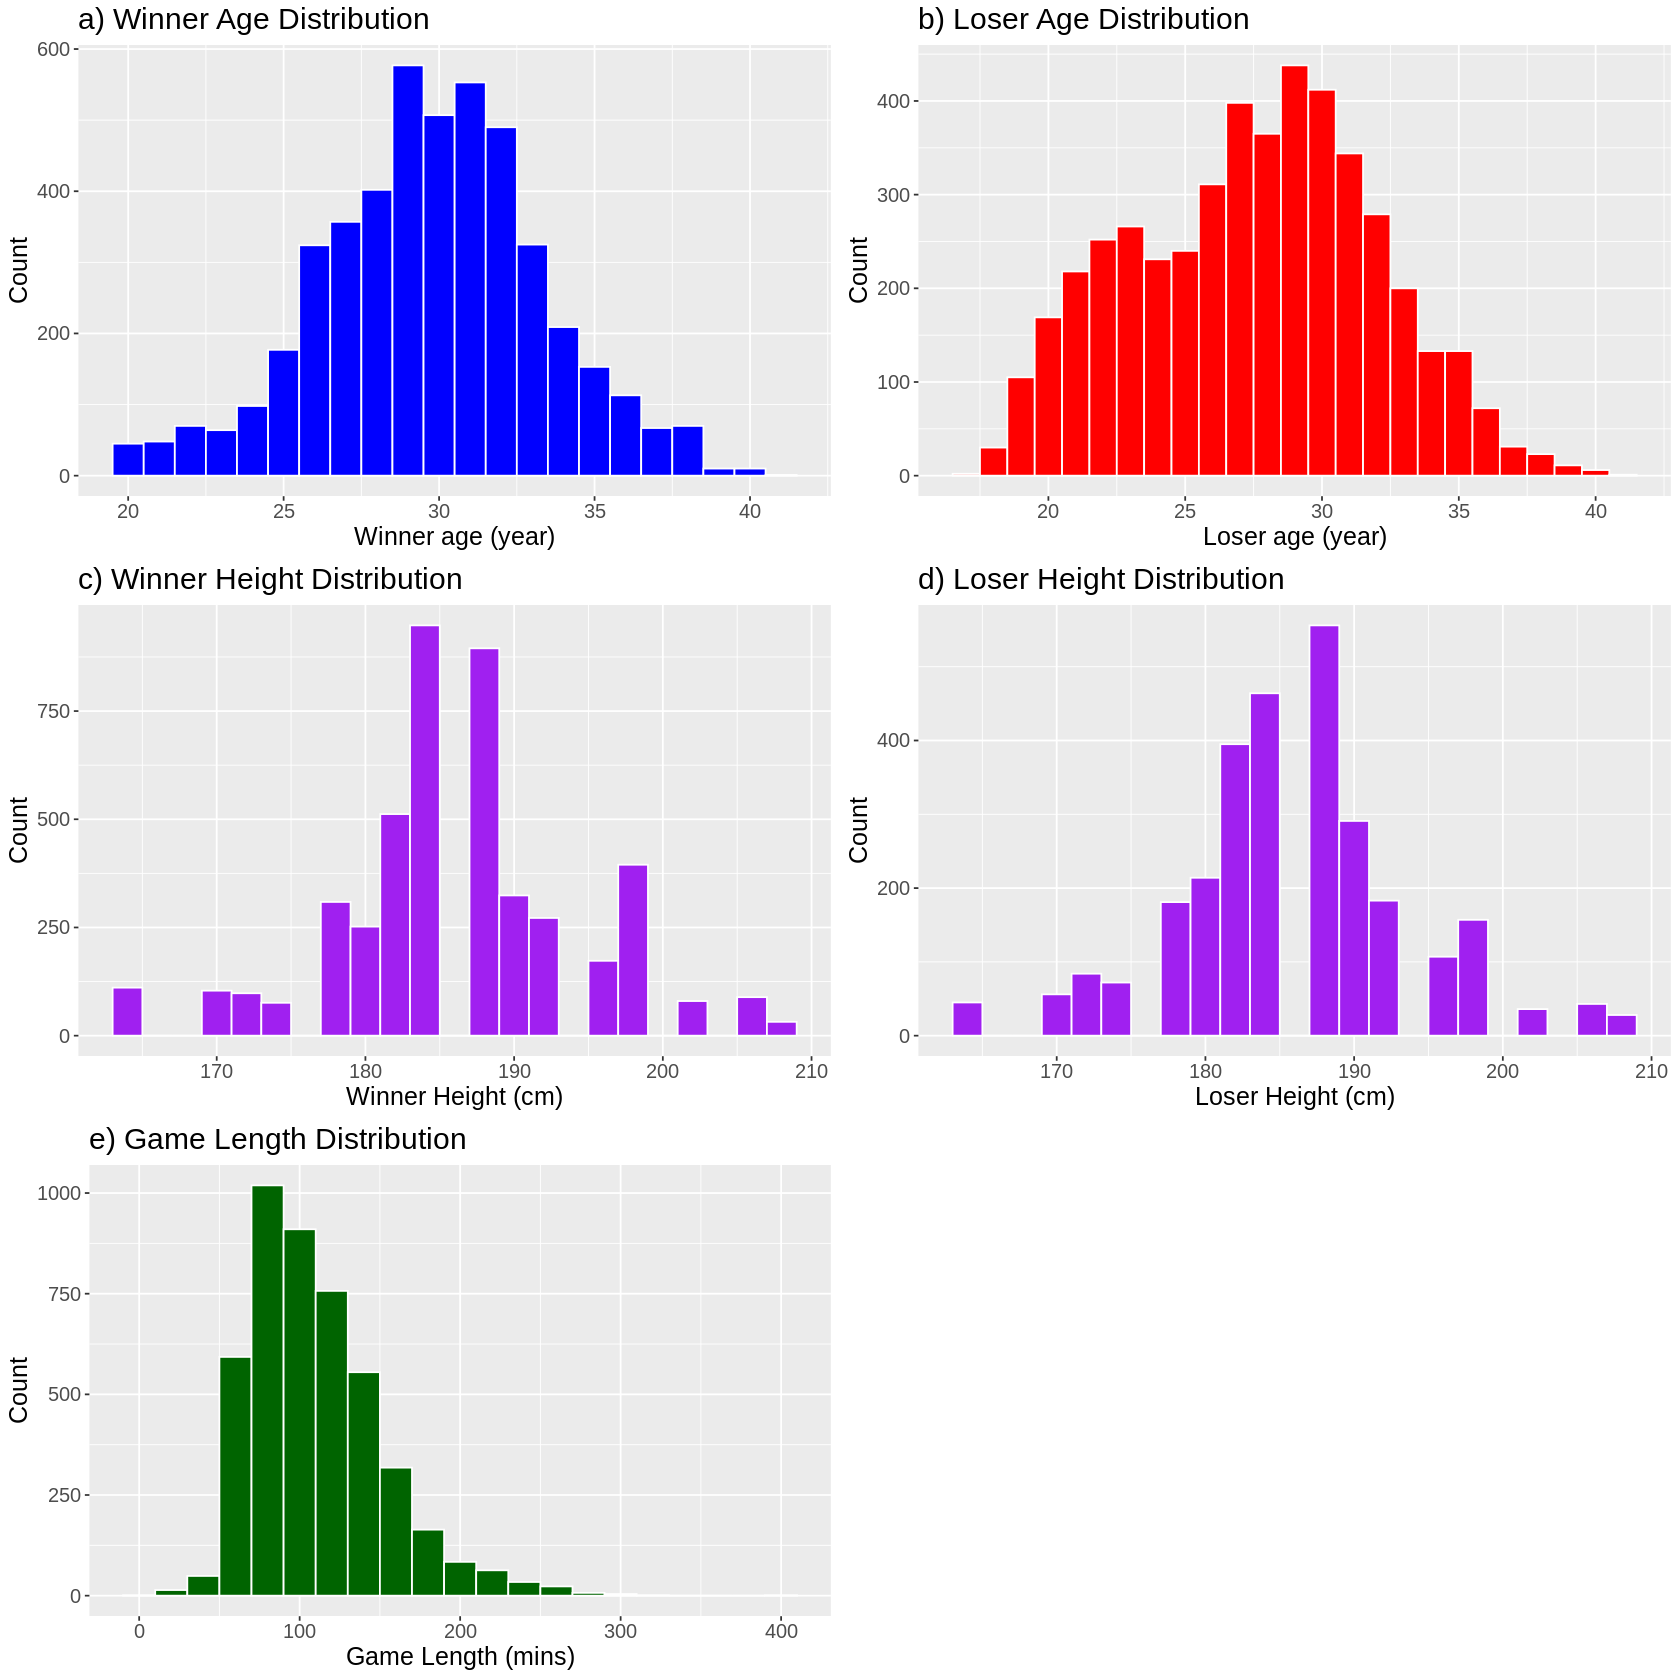

In [72]:
options(repr.plot.width=14, repr.plot.height=14)
winner_age_plot <- tennis_data |> 
    ggplot(aes(x = winner_age)) +
    geom_histogram(binwidth = 1, col = "white", fill = "blue") +
    labs(x = "Winner age (year)",
        y = "Count")+
    ggtitle("a) Winner Age Distribution") +
    theme(text = element_text(size = 15))

loser_age_plot <- tennis_data |> 
    ggplot(aes(x = loser_age)) +
    geom_histogram(binwidth = 1, col = "white", fill = "red") +
    labs(x = "Loser age (year)",
        y = "Count")+
    ggtitle("b) Loser Age Distribution") +
    theme(text = element_text(size = 15))

winner_ht_plot <- tennis_data |> 
    ggplot(aes(x = winner_ht)) +
    geom_histogram(binwidth = 2, col = "white", fill = "purple") +
    labs(x = "Winner Height (cm)",
        y = "Count") +
    ggtitle("c) Winner Height Distribution")+
    theme(text = element_text(size = 15))

loser_ht_plot <- tennis_data |> 
    ggplot(aes(x = loser_ht)) +
    geom_histogram(binwidth = 2, col = "white", fill = "purple") +
    labs(x = "Loser Height (cm)",
        y = "Count") +
    ggtitle("d) Loser Height Distribution")+
    theme(text = element_text(size = 15))

time_plot <- tennis_data |> 
    ggplot(aes(x = minutes)) +
    geom_histogram(binwidth = 20, col = "white", fill = "dark green") +
    labs(x = "Game Length (mins)",
        y = "Count") +
    ggtitle("e) Game Length Distribution")+
    theme(text = element_text(size = 15))

plot_grid(winner_age_plot, loser_age_plot, winner_ht_plot, loser_ht_plot, time_plot, ncol = 2)

**Figure 1.** **a)** Winner age distribution. Distribution is normal about the median of 30 years old. **b)** Loser age distribution. Distribution shows a slight right skew, indicating that losers are more likely to be below the age of 30, in which the median age is 28 years old. **c)** Winner height distribution. The distribution is normal about the median 185 cm. **d)** Loser height distribution. The distribution is normal about the median 185 cm. **e)** Distribution of game length in minutes. The distribution shows a right skew, indicating that game length is more likely to fall below 150 minutes, in which the median is 104 minutes. 

Warning message:
“Removed 73 rows containing missing values (geom_point).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”
Warning message:
“Removed 1806 rows containing missing values (geom_point).”


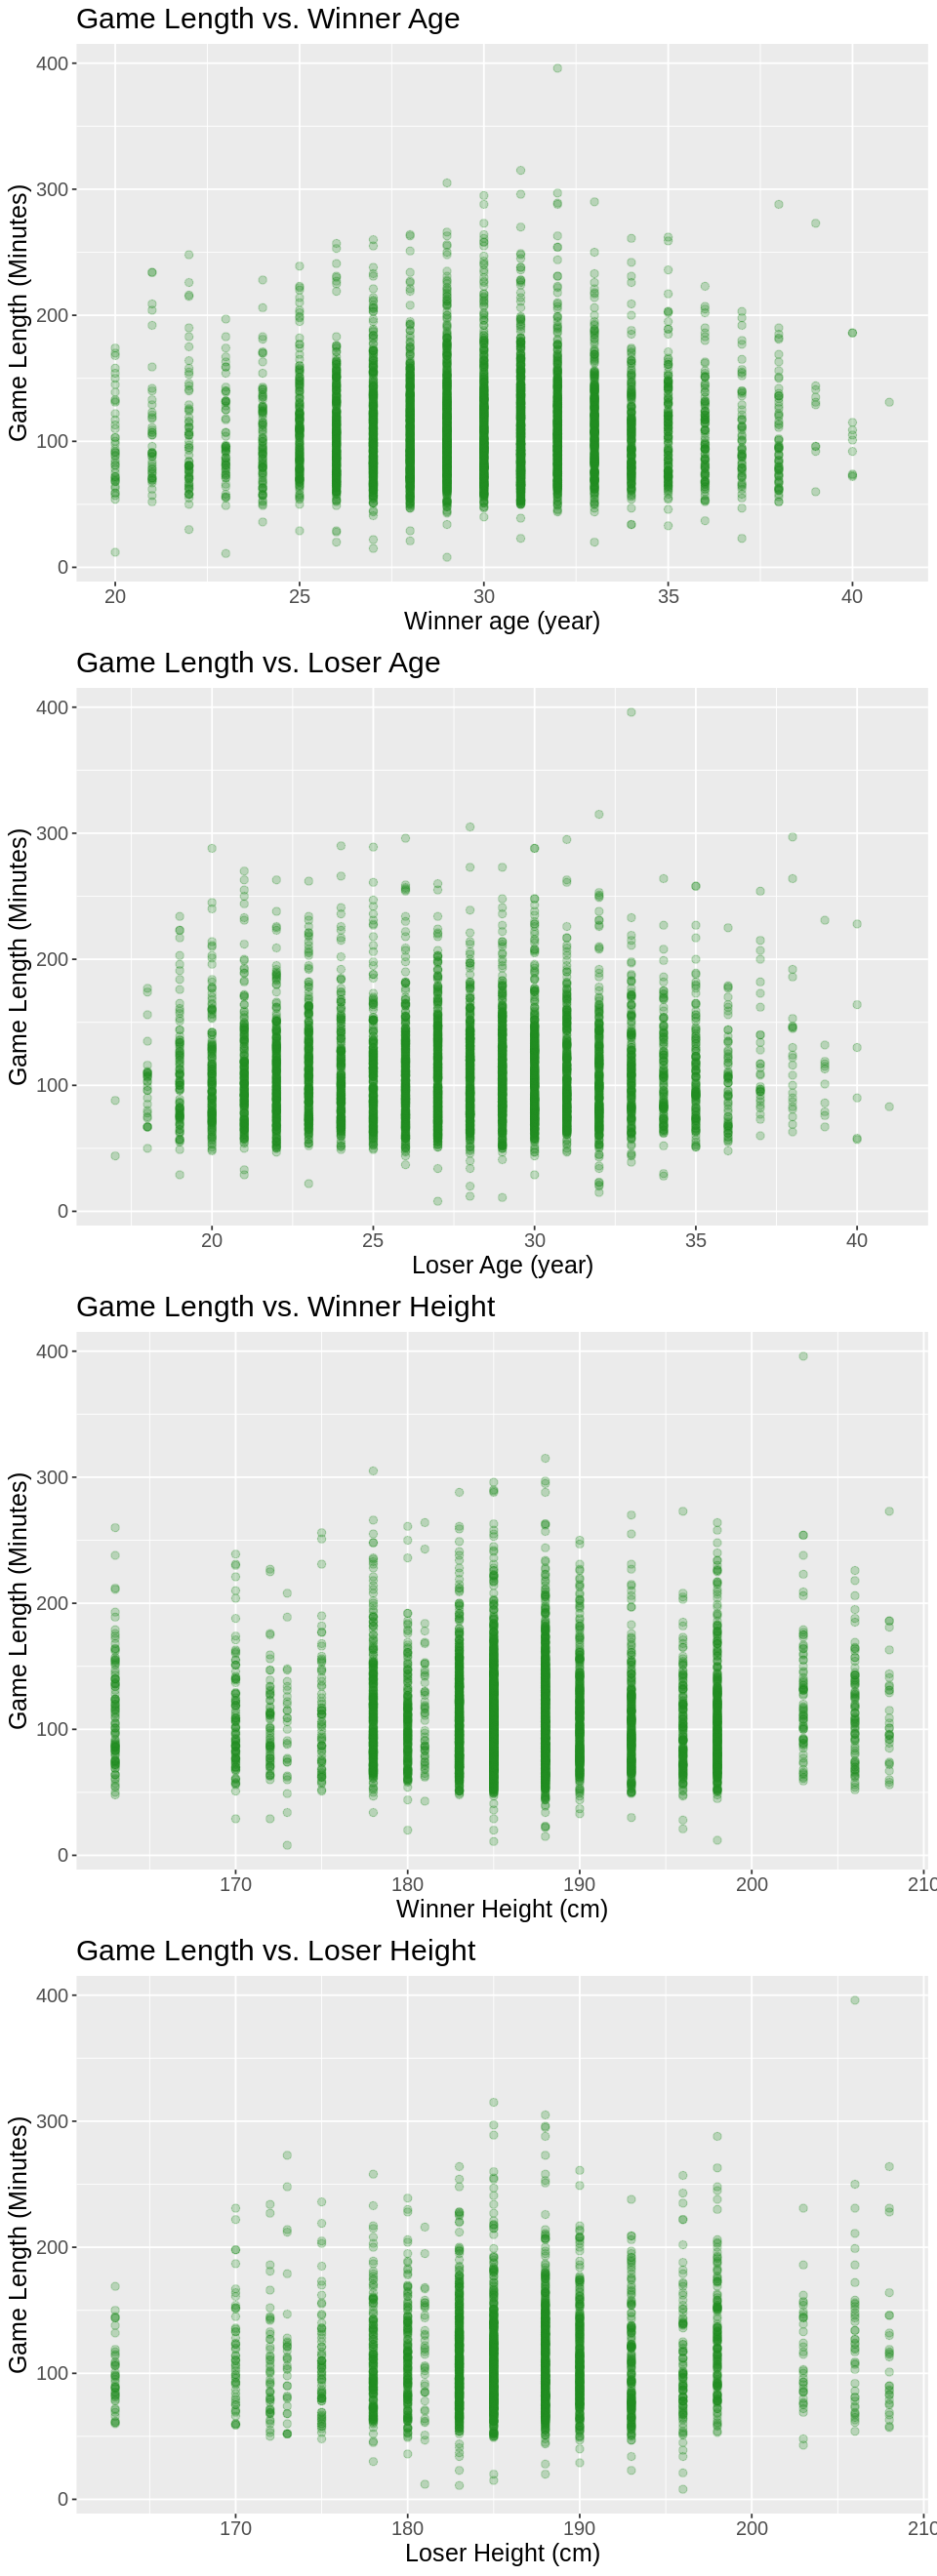

In [76]:
options(repr.plot.width=8, repr.plot.height=22)
winner_age_scatter_plot <- tennis_data |> 
    ggplot(aes(x = winner_age, y = minutes)) +
    geom_point(alpha = 0.25, size = 2, col = "forest green") +
    labs(x = "Winner Height",) +
    labs(x = "Winner age (year)",
        y = "Game Length (Minutes)") +
    ggtitle("Game Length vs. Winner Age") +
    theme(text = element_text(size = 15))

loser_age_scatter_plot <- tennis_data |> 
    ggplot(aes(x = loser_age, y = minutes)) +
    geom_point(alpha = 0.25, size = 2, col = "forest green") +
    labs(x = "Loser Age (year)",
        y = "Game Length (Minutes)") +
    ggtitle("Game Length vs. Loser Age") +
    theme(text = element_text(size = 15))

winner_ht_scatter_plot <- tennis_data |> 
    ggplot(aes(x = winner_ht, y = minutes)) +
    geom_point(alpha = 0.25, size = 2, col = "forest green") +
    labs(x = "Winner Height (cm)",
        y = "Game Length (Minutes)") +
    ggtitle("Game Length vs. Winner Height")  +
    theme(text = element_text(size = 15))

loser_ht_scatter_plot <- tennis_data |> 
    ggplot(aes(x = loser_ht, y = minutes)) +
    geom_point(alpha = 0.25, size = 2, col = "forest green") +
    labs(x = "Loser Height (cm)",
        y = "Game Length (Minutes)") +
    ggtitle("Game Length vs. Loser Height")  +
    theme(text = element_text(size = 15))

plot_grid(winner_age_scatter_plot, loser_age_scatter_plot, winner_ht_scatter_plot, loser_ht_scatter_plot, ncol = 1)

In [78]:
data_split <- initial_split(tennis_data, prop = 0.6, strata = minutes)
data_train <- training(data_split)
data_test <- testing(data_split)

In [79]:
set.seed(2000)

lm_spec <- linear_reg()|>
    set_engine("lm")|>
    set_mode("regression")

lm_recipe <- recipe(minutes ~ winner_ht + winner_age, data = data_train)

lm_fit <- workflow()|>
    add_recipe(lm_recipe)|>
    add_model(lm_spec) |>
    fit(data = data_train)
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)    winner_ht   winner_age  
  101.96458      0.00909      0.23887  


In [80]:
set.seed(2000)

loser_lm_recipe <- recipe(minutes ~ loser_age + loser_ht, data = data_train)

loser_fit <- workflow()|>
    add_recipe(loser_lm_recipe)|>
    add_model(lm_spec) |>
    fit(data = data_train)
loser_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)    loser_age     loser_ht  
   70.22770      0.06685      0.21190  


## Results

In [85]:
lm_test_result <- lm_fit |>
    predict(data_test) |>
    bind_cols(data_test) |>
    metrics(truth = minutes, estimate = .pred)
lm_test_result
lm_coeffs <- lm_fit |>
    extract_fit_parsnip() |>
    tidy()
lm_coeffs

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,41.765598283
rsq,standard,0.001898638
mae,standard,32.394836671


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.019646e+02,18.23726031,5.59100290,2.479659e-08
winner_ht,9.089616e-03,0.09430908,0.09638113,9.232249e-01
winner_age,2.388700e-01,0.21958896,1.08780494,2.767766e-01


In [86]:
loser_lm_test_result <- loser_fit |>
    predict(data_test) |>
    bind_cols(data_test) |>
    metrics(truth = minutes, estimate = .pred)
loser_lm_test_result
loser_lm_coeffs <- loser_fit |>
    extract_fit_parsnip() |>
    tidy()
loser_lm_coeffs

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,42.517991750
rsq,standard,0.004864412
mae,standard,32.887589542


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),70.22770036,25.2068227,2.7860592,0.005394944
loser_age,0.06684937,0.3093263,0.2161128,0.828925939
loser_ht,0.21189876,0.1337126,1.5847335,0.113214095


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 73 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”


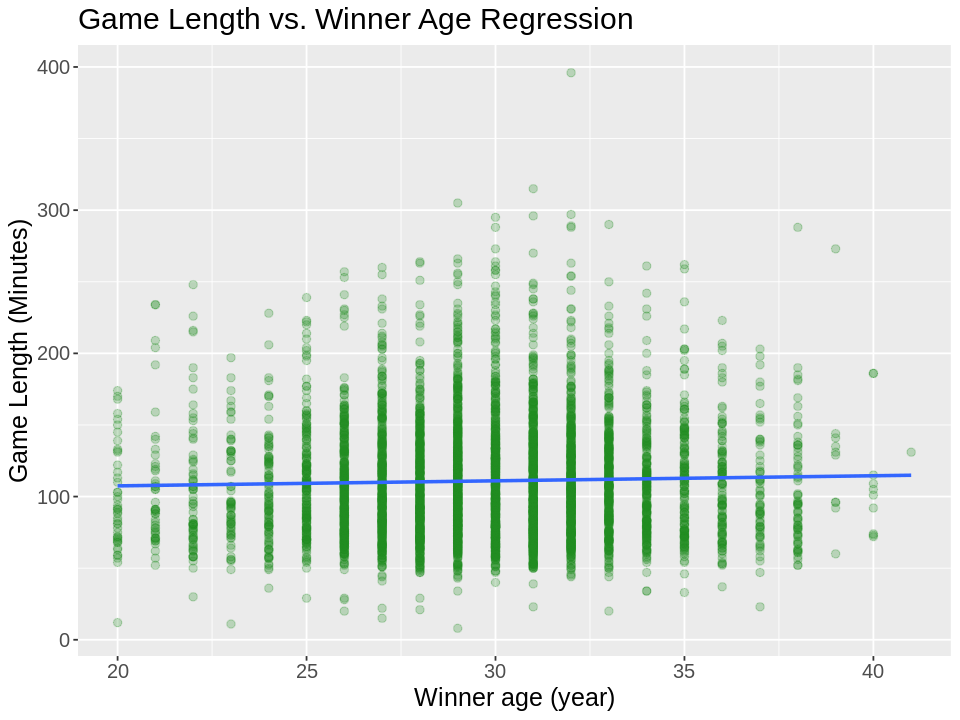

In [88]:
options(repr.plot.width=8, repr.plot.height=6)
regression_age_plot <- winner_age_scatter_plot + 
    geom_smooth(method = "lm", se = FALSE) + 
    ggtitle("Game Length vs. Winner Age Regression")
regression_age_plot

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 73 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”


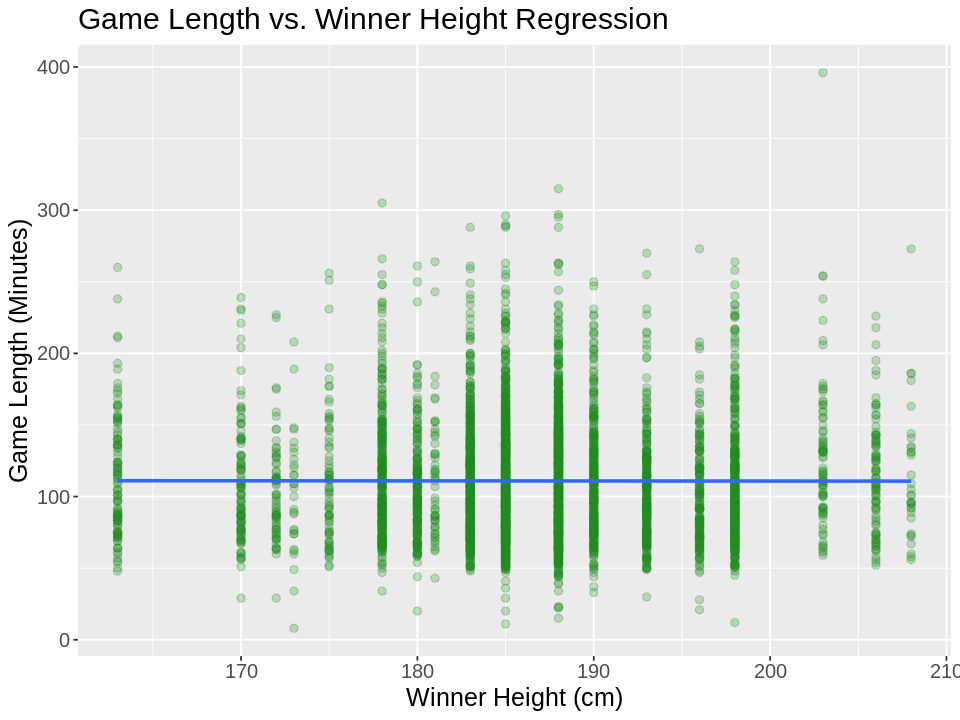

In [89]:
regression_winner_ht_plot <- winner_ht_scatter_plot + 
    geom_smooth(method = "lm", se = FALSE) + 
    ggtitle("Game Length vs. Winner Height Regression")
regression_winner_ht_plot

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 73 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”


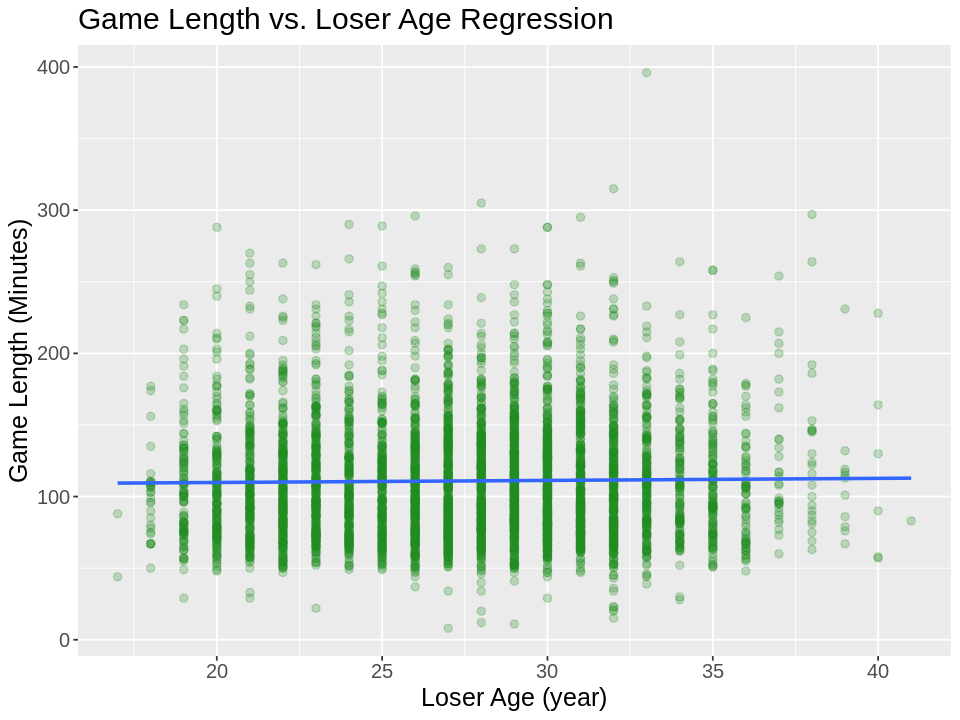

In [90]:
regression_loser_age_plot <- loser_age_scatter_plot + 
    geom_smooth(method = "lm", se = FALSE) + 
    ggtitle("Game Length vs. Loser Age Regression")
regression_loser_age_plot

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1806 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1806 rows containing missing values (geom_point).”


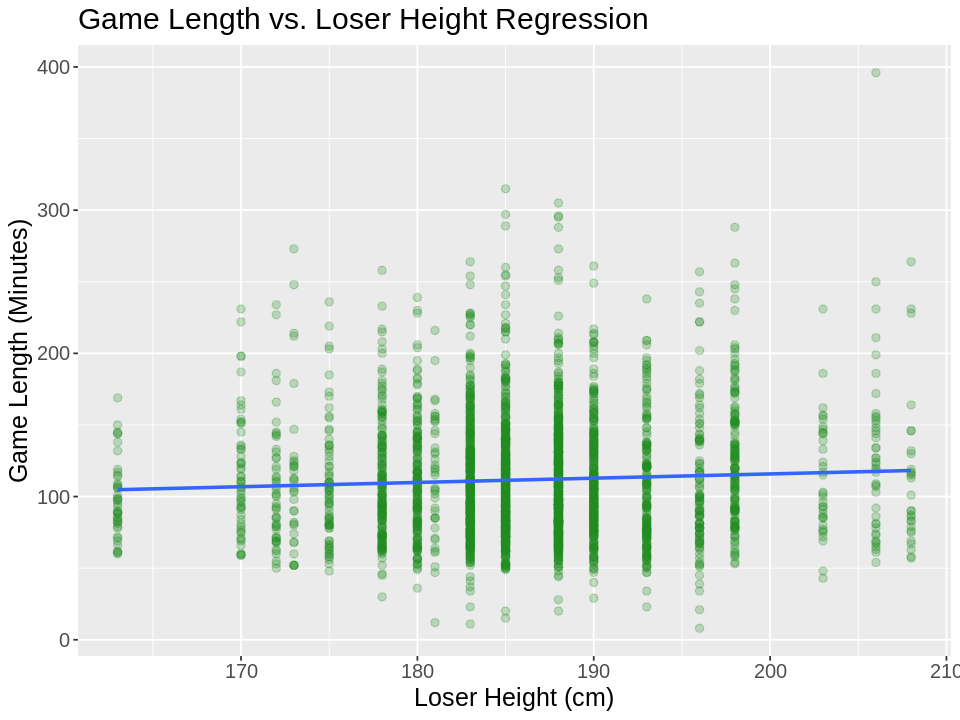

In [91]:
regression_loser_ht_plot <- loser_ht_scatter_plot + 
    geom_smooth(method = "lm", se = FALSE) + 
    ggtitle("Game Length vs. Loser Height Regression")
regression_loser_ht_plot

## Discussion